In [1]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import ligo.skymap.plot
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter

import numpy as np
import healpy as hp

import scipy
import scipy.constants as sc
import scipy.integrate as si

import gworf
from gworf import gworf

Welcome to GWORF, the Gravitational Wave Overlap Reduction Function package. In this demo we will create some differnet type of GW skies, as well as a simple PTA, then compute the corresponding overlap reduction function coefficients.

## Let's import a realistic GW sky-map

In [2]:
sky_type = 'realpop'

In [3]:
sky = np.load('./maps/{}.npy'.format(sky_type))

In [4]:
## rank SMBBH population sources from loudest in GWs to weakest
idxs = np.argsort(sky)[::-1]

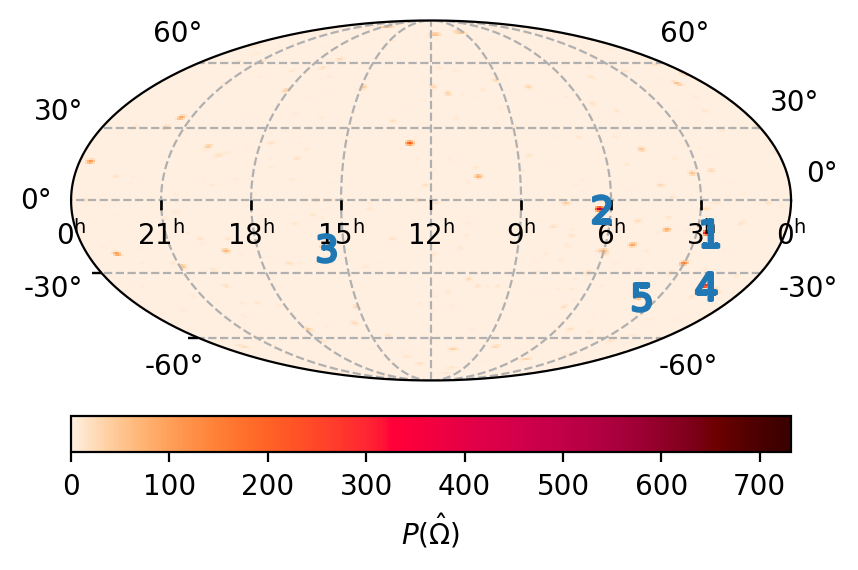

In [5]:
fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed')

cax = ax.imshow_hpx(sky, cmap='cylon',)#smooth=1.0*u.deg)
plt.colorbar(cax, orientation='horizontal',pad=0.05, label='$P(\hat\Omega)$')

for ii in range(5):
    dummy_coords = np.array(hp.pix2ang(nside=32, ipix=idxs[ii], lonlat=True))
    ax.plot(dummy_coords[0], dummy_coords[1],
                transform=ax.get_transform('world'),
                marker='${}$'.format(ii+1),
                markersize=10,
                markeredgewidth=1,
               color='C0')
plt.show()

## Compute the overlap reduction function coefficients for an array of pulsars

In [9]:
###############################################
# Set up array and prepare simply pulsar class
###############################################

npsrs = 100

psr_theta = np.arccos(np.random.uniform(-1,1,npsrs)) # uniform in costheta
psr_phi = np.random.uniform(0, 2*np.pi, npsrs) # uniform in phi
psr_dists = np.random.normal(1.0, 0.2, npsrs) * 1000 # normal around 1kpc

ptapsrs = []
for ii in range(npsrs):
    ptapsrs.append(gworf.psr(raj=psr_phi[ii], 
                             decj=np.pi/2-psr_theta[ii], 
                             dist=psr_dists[ii]))

In [10]:
#############################################
# Define pixelation scheme
#############################################
nside = 32 # pixelation
npix = hp.nside2npix(nside)    # number of pixels total
pixels = hp.pix2ang(nside, np.arange(npix), nest=False)

freq = 2.5e-9 # assume a GW frequency (only needed for pulsar-term response)

#############################################
# Define array response matrices
#############################################
F_e = gworf.signalResponse_earth(ptapsrs, pixels[0][:],
                                 pixels[1][:], dirconv=False)
F_p = gworf.signalResponse_pulsar(ptapsrs, pixels[0][:],
                                  pixels[1][:], freq=freq, dirconv=False)
F_tot = F_e - F_p

In [11]:
psrpos_phi = np.array([ptapsrs[ii].raj
                       for ii in range(len(ptapsrs))],
                       dtype=np.float64)
psrpos_theta = np.array([np.pi/2-ptapsrs[ii].decj
                         for ii in range(len(ptapsrs))],
                         dtype=np.float64)

In [14]:
## Isotropic sky is just ones in all pixels
sky_iso = np.ones(hp.nside2npix(nside))

## Realistic sky will look more like the map above
sky_realpop = sky

In [79]:
## Let's first make the overlap reduction functions the fast way
## This assumes that the pulsar term oscillates so rapidly that there
## it is completly uncorrelated between pulsars

orf_iso = gworf.orfFromMap_fast(usermap=sky_iso, response=F_e).real
orf_realpop = gworf.orfFromMap_fast(usermap=sky, response=F_e).real

In [80]:
## Cartesian unit position vectors of pulsars
psr_pos = np.column_stack((np.sin(psrpos_theta)*np.cos(psrpos_phi), 
                           np.sin(psrpos_theta)*np.sin(psrpos_phi), 
                           np.cos(psrpos_theta)))

In [81]:
## Angular separations between pulsars
psr_angseps = np.arccos(np.tensordot(psr_pos, 
                                     psr_pos.T, 
                                     axes=1))
np.fill_diagonal(psr_angseps, 0) # account for numerical error
psr_angseps = (psr_angseps + psr_angseps.T) / 2

/Users/taylosr8/miniconda3/envs/gworf_demo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.


In [82]:
## Grab the upper triangle of the various pulsar x pulsar matrices
flat_angseps = psr_angseps[np.triu_indices(npsrs,k=0)]
flat_orf_iso = orf_iso[np.triu_indices(npsrs,k=0)]
flat_orf_realpop = orf_realpop[np.triu_indices(npsrs,k=0)]

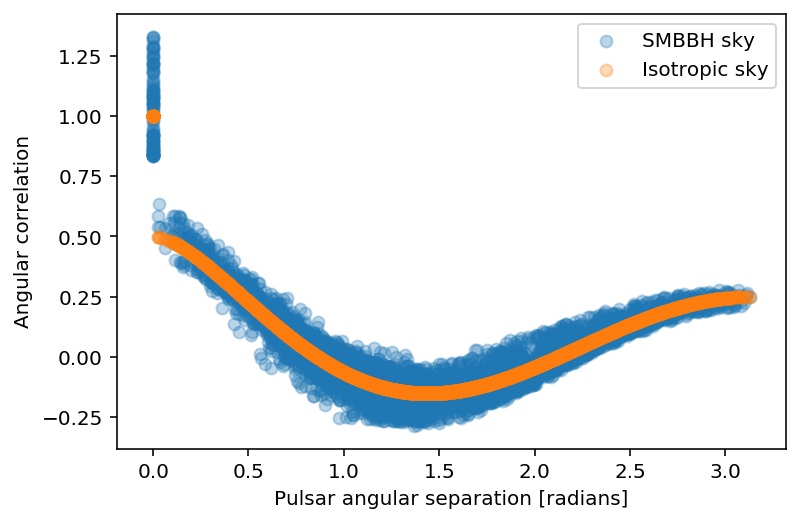

In [83]:
## Plot these
plt.scatter(flat_angseps, flat_orf_realpop, alpha=0.3, label='SMBBH sky');
plt.scatter(flat_angseps, flat_orf_iso, alpha=0.3, label='Isotropic sky');

plt.xlabel('Pulsar angular separation [radians]')
plt.ylabel('Angular correlation')
plt.legend()
plt.show()

GWORF is fast for any type of sky. The array response matrices are fixed by the PTA i.e. the detector. So it simple to change the angular power distribution arbitrarily to calculate the inter-pulsar correlation coefficients for any type of sky.

## We didn't actually use the pulsar term explicitly in our calculations. Let's bring it back in to check the effect.

In [78]:
orf_iso_tot = np.dot(F_tot * np.repeat(sky_iso,2), np.conj(F_tot).T).real

In [84]:
flat_orf_iso_tot = orf_iso_tot[np.triu_indices(npsrs,k=0)]

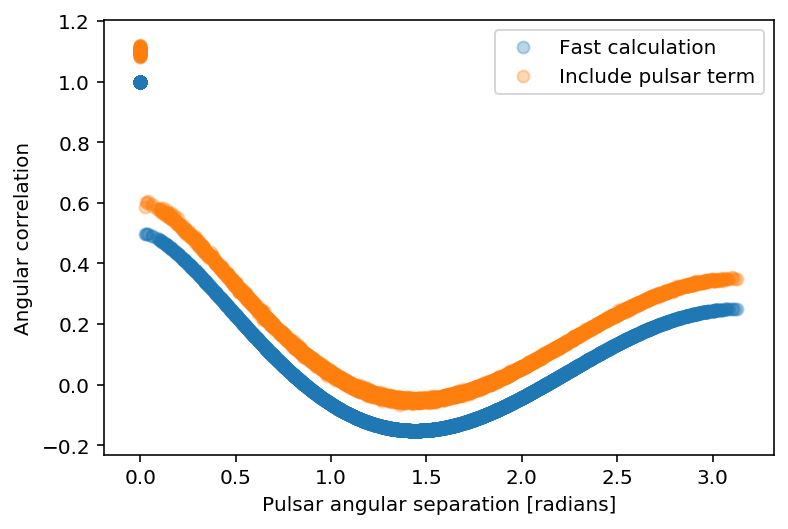

In [87]:
## Plot these
plt.scatter(flat_angseps, flat_orf_iso, alpha=0.3, label='Fast calculation');
plt.scatter(flat_angseps, flat_orf_iso_tot+0.1, alpha=0.3, label='Include pulsar term');

plt.xlabel('Pulsar angular separation [radians]')
plt.ylabel('Angular correlation')
plt.legend()
plt.show()

## These look equivalent within error tolerances to me!